In [1]:
from custom_tokenizers.jieba_tokenizer import JiebaLikeTokenizer
from datasets import load_dataset

from model_instancies import model1

import torch
from trainer import SimpleTrainer

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/cq/3ryty8mx6qz8cqtn1ghkrvmm0000gn/T/jieba.cache
Loading model cost 0.252 seconds.
Prefix dict has been built successfully.


In [2]:
# Load and prepare dataset
dataset = load_dataset("parquet", data_files="../data/training_data/training_corpus.parquet")["train"]
dataset = dataset.shuffle(seed=42)
# dataset = dataset.select(range(10000))
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_data = dataset['train']
val_data = dataset['test']

In [3]:
print(train_data)
print(val_data)

Dataset({
    features: ['input', 'label'],
    num_rows: 2999171
})
Dataset({
    features: ['input', 'label'],
    num_rows: 749793
})


In [4]:
print(train_data[0])

{'input': ['彪形大汉', '大惊失色', '，', '知道', '9', '4', '5', '4'], 'label': '自己'}


In [4]:
tokenizer = JiebaLikeTokenizer()

def preprocess(example):
    return {
        "input_ids": tokenizer.convert_tokens_to_ids(example["input"]),
        "labels": tokenizer.convert_tokens_to_ids([example["label"]], padding=False)[0],
    }

def add_attention_mask(example, tokenizer=tokenizer):
    return {
        "attention_mask": [0 if input_id==tokenizer.pad_token_id else 1 for input_id in example["input_ids"]],
    }

train_data = train_data.map(preprocess, num_proc=4, remove_columns=train_data.column_names)
val_data = val_data.map(preprocess, num_proc=4, remove_columns=val_data.column_names)
train_data = train_data.map(add_attention_mask, num_proc=4)
val_data = val_data.map(add_attention_mask, num_proc=4)

In [5]:
model = model1()

In [6]:
batch_size = 32
num_epochs = 2
eval_interval = len(val_data) // batch_size

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainer = SimpleTrainer(
    model=model,
    train_dataset=train_data,
    val_dataset=val_data,
    batch_size=batch_size,
    num_epochs=num_epochs,
    device=device,
    eval_strategy="batch",
    eval_interval=eval_interval,
)

In [7]:
trainer.train()

Epoch 1:   0%|          | 0/93725 [00:00<?, ?it/s]

[Step 23431] Training - loss: 5.9278, accuracy: 0.2188
[Step 23431] Validation - loss: 142036.1108, accuracy: 0.1680
New best model saved
[Step 46862] Training - loss: 5.7581, accuracy: 0.1562
[Step 46862] Validation - loss: 127327.0632, accuracy: 0.2137
New best model saved
[Step 70293] Training - loss: 5.4854, accuracy: 0.1562
[Step 70293] Validation - loss: 117230.6961, accuracy: 0.2562
New best model saved
[Step 93724] Training - loss: 5.4152, accuracy: 0.2500
[Step 93724] Validation - loss: 109750.3752, accuracy: 0.2917
New best model saved


Epoch 2:   0%|          | 0/93725 [00:00<?, ?it/s]

[Step 23431] Training - loss: 4.9331, accuracy: 0.2500
[Step 23431] Validation - loss: 104235.2029, accuracy: 0.3214
New best model saved
[Step 46862] Training - loss: 4.7032, accuracy: 0.2812
[Step 46862] Validation - loss: 100191.9272, accuracy: 0.3456
New best model saved
[Step 70293] Training - loss: 4.4180, accuracy: 0.2500
[Step 70293] Validation - loss: 97792.6728, accuracy: 0.3617
New best model saved
[Step 93724] Training - loss: 5.1815, accuracy: 0.1875
[Step 93724] Validation - loss: 95141.8585, accuracy: 0.3777
New best model saved


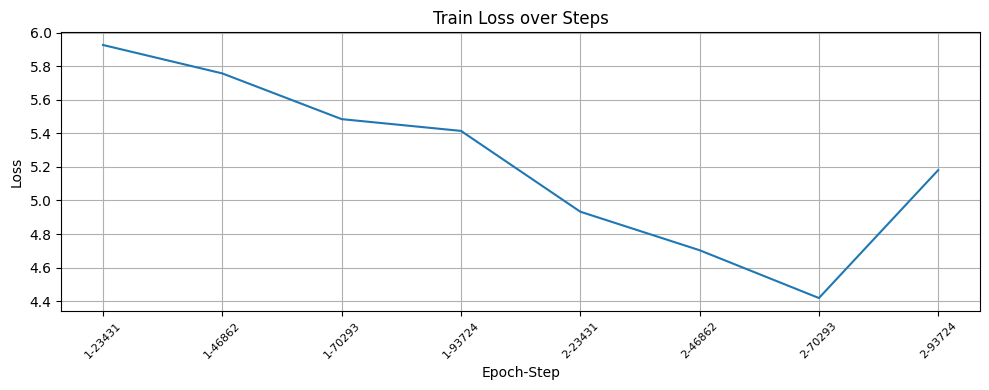

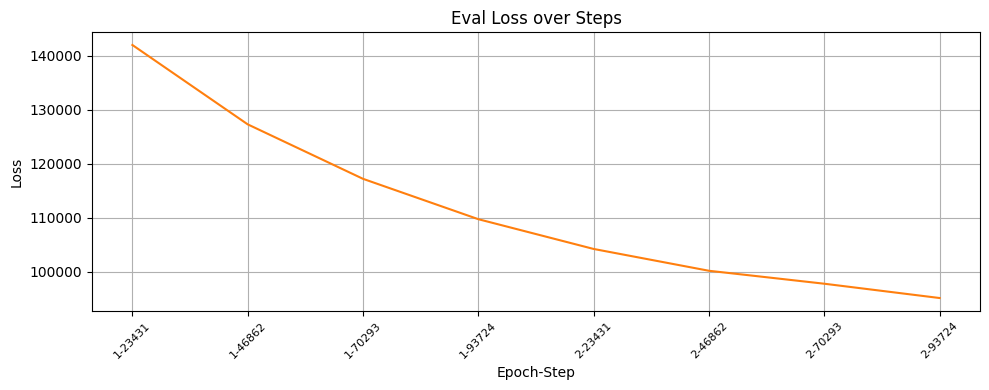

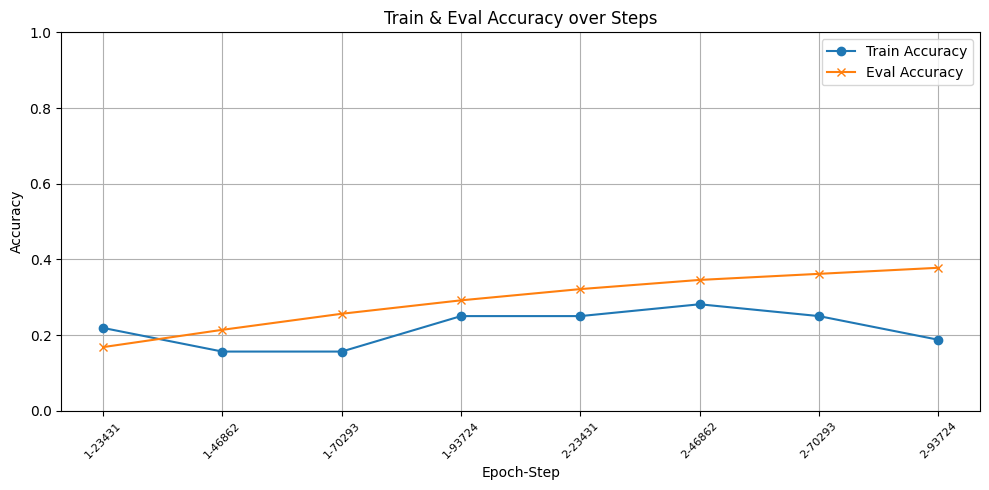

In [8]:
trainer.plot_training_log()

In [10]:
trainer.save_best_model("../models/model_save/model1_train1.pth")

Best model saved to ../models/model1_train1.pth
